## Importing and Installation

In [1]:
from os.path import splitext
from typing import List, Tuple, Set, Dict, Optional, Iterable, Pattern
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(f'Device: {device}')

Device: cpu


## Classes

### DistMult

In [2]:
# Let's create a PyTorch link prediction model -- we will use the DistMult scoring function

class DistMult(nn.Module):
    def __init__(self, nb_entities: int, nb_predicates: int, embedding_size: int):
        super().__init__()
        self.nb_entities = nb_entities
        self.nb_predicates = nb_predicates
        self.embedding_size = embedding_size

        # This is the encoder part of the model, and the emeddings for the entities and relation types
        # represent the parameters θ of the encoder.
        self.entity_embeddings = nn.Embedding(nb_entities, self.embedding_size, sparse=True)
        self.predicate_embeddings = nn.Embedding(nb_predicates, self.embedding_size, sparse=True)

        # Small trick from https://github.com/facebookresearch/kbc/
        self.entity_embeddings.weight.data *= 1e-3
        self.predicate_embeddings.weight.data *= 1e-3

    def score(self, triple: Tensor) -> Tensor:
        # triple is a batch_size x 3 tensor containing a batch of triples, where triple[0], triple[1], and triple[2]
        # correspond to the indices of the subjects, predicates, and objects, respectively.

        # We first look up the embedding of the subjects, predicates, and objects of the input triples ..
        s_emb = self.entity_embeddings(triple[:, 0])
        p_emb = self.predicate_embeddings(triple[:, 1])
        o_emb = self.entity_embeddings(triple[:, 2])

        # [B] Tensor
        # .. and then compute the tri-linear dot product <s, p, o>, producing the resulting scores.
        res = torch.sum(s_emb * p_emb * o_emb, 1)

        # [B] Tensor
        return res

    def forward(self, s: Optional[Tensor], p: Optional[Tensor], o: Optional[Tensor]) -> Tensor:
        # s, p, and o are the indices of subjects, predicates, and objects, respecitvely.
        # This function is similar to the previous score() but it requires you not to specify one among the
        # subject, predicate, and object of a batch of triples, and gives you a score for all possible candidates
        assert [s, p, o].count(None) <= 1, "s, p, or o should be None"

        s_emb = self.entity_embeddings(s) if s is not None else self.entity_embeddings.weight
        p_emb = self.predicate_embeddings(p) if p is not None else self.predicate_embeddings.weight
        o_emb = self.entity_embeddings(o) if o is not None else self.entity_embeddings.weight

        # [B] Tensor
        scores = None

        if p is None:
          # If the predicate is not specified, we compute the scores of all the triples obtained by using the
          # predicates in R as predicate values.
          scores = (s_emb * o_emb) @ p_emb.t()
        elif s is None:
          # If the subject is not specified, we compute the scores of all the triples obtained by using the
          # entities in E as subject values.
          scores = (p_emb * o_emb) @ s_emb.t()
        elif o is None:
          # If the object is not specified, we compute the scores of all the triples obtained by using the
          # entities in E as object values.
          scores = (s_emb * p_emb) @ o_emb.t()
        else:
          # Subject, predicare, and object values were specified -- we compute the score of the triple.
          scores = self.score(torch.cat([s.view(-1, 1), p.view(-1, 1), o.view(-1, 1)], dim=1))

        assert scores is not None
        return scores

    def factor(self, idx: Tensor, is_entity: bool = True) -> Tensor:
      # This method is used for regularisation -- more on this later.
      embedding_layer = self.entity_embeddings if is_entity is True else self.predicate_embeddings
      emb = embedding_layer(idx)
      return emb

### ComplEx

In [3]:
class ComplEx(nn.Module):
    def __init__(self, nb_entities: int, nb_predicates: int, embedding_size: int):
        super().__init__()
        self.nb_entities = nb_entities
        self.nb_predicates = nb_predicates
        self.embedding_size = embedding_size

        # Remeber that ComplEx has complex embeddings -- here we will use
        # x[:embedding_size] as the real part, and x[embedding_size:] as the
        # imaginary part of the representations
        self.entity_embeddings = nn.Embedding(nb_entities, self.embedding_size * 2, sparse=True)
        self.predicate_embeddings = nn.Embedding(nb_predicates, self.embedding_size * 2, sparse=True)

        # Small trick from https://github.com/facebookresearch/kbc/
        self.entity_embeddings.weight.data *= 1e-3
        self.predicate_embeddings.weight.data *= 1e-3

    def score(self, triple: Tensor) -> Tensor:
        # triple is a batch_size x 3 tensor containing a batch of triples, where triple[0], triple[1], and triple[2]
        # correspond to the indices of the subjects, predicates, and objects, respectively.

        s_emb = self.entity_embeddings(triple[:, 0])
        p_emb = self.predicate_embeddings(triple[:, 1])
        o_emb = self.entity_embeddings(triple[:, 2])

        # [B, E]
        s_real, s_img = s_emb[:, :self.embedding_size], s_emb[:, self.embedding_size:]
        p_real, p_img = p_emb[:, :self.embedding_size], p_emb[:, self.embedding_size:]
        o_real, o_img = o_emb[:, :self.embedding_size], o_emb[:, self.embedding_size:]

        # [B] Tensor
        # This computes Re(<s, p, conj(o)>)
        res = torch.sum((s_real * o_real + s_img * o_img) * p_real +
                        (s_real * o_img - s_img * o_real) * p_img, 1)

        # [B] Tensor
        return res

    def forward(self, s: Optional[Tensor], p: Optional[Tensor], o: Optional[Tensor]) -> Tensor:
        # s, p, and o are the indices of subjects, predicates, and objects, respecitvely.
        # This function is similar to the previous score() but it requires you not to specify one among the
        # subject, predicate, and object of a batch of triples, and gives you a score for all possible candidates
        assert [s, p, o].count(None) <= 1, "s, p, or o should be None"

        s_emb = self.entity_embeddings(s) if s is not None else self.entity_embeddings.weight
        p_emb = self.predicate_embeddings(p) if p is not None else self.predicate_embeddings.weight
        o_emb = self.entity_embeddings(o) if o is not None else self.entity_embeddings.weight

        # Let's extract the real and imaginary part from the subject, predicate, and object embeddings
        s_real, s_img = s_emb[:, :self.embedding_size], s_emb[:, self.embedding_size:]
        p_real, p_img = p_emb[:, :self.embedding_size], p_emb[:, self.embedding_size:]
        o_real, o_img = o_emb[:, :self.embedding_size], o_emb[:, self.embedding_size:]

        # [B] Tensor
        scores = None

        if p is None:
          # If the predicate is not specified, we compute the scores of all the triples obtained by using the
          # predicates in R as predicate values.
          scores1_p = (s_real * o_real + s_img * o_img) @ p_real.t()
          scores2_p = (s_real * o_img - s_img * o_real) @ p_img.t()
          scores = scores1_p + scores2_p
        elif s is None:
          # If the subject is not specified, we compute the scores of all the triples obtained by using the
          # entities in E as subject values.
          scores1_s = (p_real * o_real + p_img * o_img) @ s_real.t()
          scores2_s = (p_real * o_img - p_img * o_real) @ s_img.t()
          scores = scores1_s + scores2_s
        elif o is None:
          # If the object is not specified, we compute the scores of all the triples obtained by using the
          # entities in E as object values.
          scores1_o = (p_real * s_real - p_img * s_img) @ o_real.t()
          scores2_o = (p_real * s_img + p_img * s_real) @ o_img.t()
          scores = scores1_o + scores2_o
        else:
          # Subject, predicare, and object values were specified -- we compute the score of the triple.
          scores = self.score(torch.cat([s.view(-1, 1), p.view(-1, 1), o.view(-1, 1)], dim=1))

        assert scores is not None
        return scores

    def factor(self, idx: Tensor, is_entity: bool = True) -> Tensor:
      embedding_layer = self.entity_embeddings if is_entity is True else self.predicate_embeddings
      emb = embedding_layer(idx)
      emb_real, emb_img = emb[:, :self.embedding_size], emb[:, self.embedding_size:]
      return torch.sqrt(emb_real ** 2 + emb_img ** 2)

### Regularisers

In [4]:
class F2(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, factors: List[Tensor]):
        norm = sum(torch.sum(f ** 2) for f in factors)
        return norm / factors[0].shape[0]

class N3(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, factors: List[Tensor]):
        norm = sum(torch.sum(torch.abs(f) ** 3) for f in factors)
        return norm / factors[0].shape[0]

## Functions

In [5]:
def read_triples(path: str) -> List[Tuple[str, str, str]]:
    triples = []
    with open(path, 'rt') as f:
      for line in f:
        s, p, o = line.split('\t')
        triples += [(s.strip(), p.strip(), o.strip())]
    return triples

# Convert the training, validation, and test sets to numpy matrices with shape |S| x 3
def triples_to_matrix(triple_lst: List[Tuple[str, str, str]], ent_to_id, pred_to_id) -> np.array:
    index_lst = [(ent_to_id[s], pred_to_id[p], ent_to_id[o]) for s, p, o in triple_lst]
    return np.array(index_lst, dtype=np.int32)

# Evaluation function
def evaluate(test_triples: Tensor, all_triples: Tensor, model: nn.Module, batch_size: int = 8192):
    sp_to_o, po_to_s = {}, {}

    # We need these to compute the filtered ranks
    for s, p, o in all_triples:
        s_idx, p_idx, o_idx = s.item(), p.item(), o.item()

        sp_key = (s_idx, p_idx)
        po_key = (p_idx, o_idx)

        if sp_key not in sp_to_o:
            sp_to_o[sp_key] = []

        if po_key not in po_to_s:
            po_to_s[po_key] = []

        sp_to_o[sp_key] += [o_idx]
        po_to_s[po_key] += [s_idx]

    hits = dict()
    hits_l = dict()
    hits_r = dict()

    hits_at = [1, 3, 5, 10, 20, 50, 100]

    for hits_at_value in hits_at:
        hits[hits_at_value] = 0.0
        hits_l[hits_at_value] = 0.0
        hits_r[hits_at_value] = 0.0

    def hits_at_n(n_, rank, is_left=True):
        if rank <= n_:
            hits[n_] = hits.get(n_, 0) + 1

            hits_x = hits_l if is_left else hits_r
            hits_x[n_] = hits_x.get(n_, 0) + 1

    counter = 0
    mrr = 0.0

    dataset = TensorDataset(test_triples)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    ranks_l, ranks_r = [], []

    for batch_ in data_loader:
        batch_triples = batch_[0]
        batch_size = batch_triples.shape[0]
        counter += batch_size * 2

        with torch.inference_mode():
            scores_o = model.forward(s=batch_triples[:, 0], p=batch_triples[:, 1], o=None).cpu().numpy()
            scores_s = model.forward(s=None, p=batch_triples[:, 1], o=batch_triples[:, 2]).cpu().numpy()

        for elem_idx in range(batch_size):
            s_idx, p_idx, o_idx = batch_triples[elem_idx, 0], batch_triples[elem_idx, 1], batch_triples[elem_idx, 2]

            # Code for the filtered setting
            sp_key = (s_idx.item(), p_idx.item())
            po_key = (p_idx.item(), o_idx.item())

            o_to_remove = sp_to_o[sp_key]
            s_to_remove = po_to_s[po_key]

            for tmp_o_idx in o_to_remove:
                if tmp_o_idx != o_idx:
                    scores_o[elem_idx, tmp_o_idx] = - np.infty

            for tmp_s_idx in s_to_remove:
                if tmp_s_idx != s_idx:
                    scores_s[elem_idx, tmp_s_idx] = - np.infty
            # End of code for the filtered setting

            rank_l = 1 + np.argsort(np.argsort(- scores_s[elem_idx, :]))[s_idx]
            rank_r = 1 + np.argsort(np.argsort(- scores_o[elem_idx, :]))[o_idx]

            ranks_l += [rank_l]
            ranks_r += [rank_r]

            mrr += 1.0 / rank_l
            mrr += 1.0 / rank_r

            for n in hits_at:
                hits_at_n(n, rank_l, is_left=True)

            for n in hits_at:
                hits_at_n(n, rank_r, is_left=False)

    counter = float(counter)

    mrr /= counter

    for n in hits_at:
        hits[n] /= counter
        hits_l[n] /= (counter // 2)
        hits_r[n] /= (counter // 2)

    metrics = dict()
    metrics['mrr'] = mrr
    for n in hits_at:
        metrics['hits@{}'.format(n)] = hits[n]

        metrics['hits_l@{}'.format(n)] = hits_l[n]
        metrics['hits_r@{}'.format(n)] = hits_r[n]

    metrics['ranks_l'] = ranks_l
    metrics['ranks_r'] = ranks_r

    return metrics

## Main Function To Run Entire Code

In [10]:
def main(train_path, valid_path, test_path, img_path, mod = 'comp'):

    # Reading the triples
    train_triples_lst = read_triples(train_path)
    valid_triples_lst = read_triples(valid_path)
    test_triples_lst = read_triples(test_path)

    # --------------- Mapping all Entities and Relations ---------------
    all_triples_lst: List[Tuple[str, str, str]] = train_triples_lst + valid_triples_lst + test_triples_lst

    # Set E of all entities
    entity_set: Set[str] = {s for s, _, _ in all_triples_lst} | {o for _, _, o in all_triples_lst}
    # Set R of all relation types
    predicate_set: Set[str] = {p for _, p, _ in all_triples_lst}

    # Map every entity and predicate with an unique index from 0 to |E|
    entity_lst: List[str] = sorted(entity_set)
    predicate_lst: List[str] = sorted(predicate_set)

    # Entity/predicate -> index maps
    entity_to_idx: Dict[str, int] = {entity: idx for idx, entity in enumerate(entity_lst)}
    predicate_to_idx: Dict[str, int] = {predicate: idx for idx, predicate in enumerate(predicate_lst)}

    # Index -> entity/predicate maps
    idx_to_entity: Dict[int, str] = {idx: entity for entity, idx in entity_to_idx.items()}
    idx_to_predicate: Dict[int, str] = {idx: predicate for predicate, idx in predicate_to_idx.items()}


    # --------------- Converting all triples to matrix ---------------
    train_np = triples_to_matrix(train_triples_lst, entity_to_idx, predicate_to_idx)
    valid_np = triples_to_matrix(valid_triples_lst, entity_to_idx, predicate_to_idx)
    test_np = triples_to_matrix(test_triples_lst, entity_to_idx, predicate_to_idx)
    all_np = triples_to_matrix(all_triples_lst, entity_to_idx, predicate_to_idx)

    # --------------- Converting the matrix to tensors ---------------
    train_t = torch.tensor(train_np, dtype=torch.long, device=device)
    valid_t = torch.tensor(valid_np, dtype=torch.long, device=device)
    test_t = torch.tensor(test_np, dtype=torch.long, device=device)
    all_t = torch.tensor(all_np, dtype=torch.long, device=device)

    # --------------- Creating model with stock embeddings ---------------
    nb_entities = len(entity_set)
    nb_predicates = len(predicate_set)

    embedding_size = 500
    if mod == 'comp':
        model = ComplEx(nb_entities=nb_entities, nb_predicates=nb_predicates, embedding_size=embedding_size).to(device)
    elif mod == 'dist':
        model = DistMult(nb_entities=nb_entities, nb_predicates=nb_predicates, embedding_size=embedding_size).to(device)

    print(model)

    # ---------------- Model Training ---------------
    # Parameters of the model
    optimiser = optim.Adagrad(model.parameters(), lr=0.1)
    regulariser = F2()
    nb_epochs = 50
    batch_size = 128
    regulariser_weight = 0.001

    dataset = TensorDataset(train_t)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()

    # Setting livelossplot parameters
    group_patterns: Iterable[Tuple[Pattern, str]] = (
        (r'^(subject(_|-))(.*)', 'subject'),
        (r'^(object(_|-))(.*)', 'object'),
        (r'^(aggregate(_|-))(.*)', 'aggregate'),
        (r'^(train(_|-))(.*)', 'training'),
        (r'^(val(_|-))(.*)', 'validation'),
        (r'^(test(_|-))(.*)', 'test'),
    )

    img_name = train_path.split('/')[-1].split('.')[0] + '.png'
    liveloss = PlotLosses(group_patterns=group_patterns,
                          outputs=[MatplotlibPlot(figpath = img_path + img_name)])
    loss_function = nn.CrossEntropyLoss(reduction='mean')

    # Saving the best logs
    best_logs = {'subject_loss': float('inf'), 'object_loss': float('inf'), 'aggregate_loss': float('inf'),
                 'train_MRR': 0, 'val_MRR': 0, 'test_MRR': 0}

    # Training Loop
    for epoch_no in range(1, nb_epochs + 1):
        for batch_no, batch in enumerate(data_loader):
            triple_batch = batch[0]
            # Given the predicate and the object of the triple, compute a score for all possible subjects
            s_scores = model.forward(s=None, p=triple_batch[:, 1], o=triple_batch[:, 2])

            # Given the subject and the predicate of the triple, compute a scofe for all possible objects
            o_scores = model.forward(s=triple_batch[:, 0], p=triple_batch[:, 1], o=None)

            # Calculate the mismatch between the predicted scores and the gold truth -- the true subjects and objects of the triples
            s_loss = loss_function(s_scores, triple_batch[:, 0])
            o_loss = loss_function(o_scores, triple_batch[:, 2])

            factors = [model.factor(triple_batch[:, 0], is_entity=True),
                    model.factor(triple_batch[:, 1], is_entity=False),
                    model.factor(triple_batch[:, 2], is_entity=True)]

            # The loss is given by the "mismatch (loss) value" mentioned earlier, and a regularisation term
            loss = s_loss + o_loss + regulariser_weight * regulariser(factors)

            optimiser.zero_grad()

            # Compute the gradient of the training objective (L(θ) + λΩ(θ)) with respect to θ (entity and predicate embeddings)
            loss.backward()

            # Perform one stochastic gradient descent step
            optimiser.step()

        train_metrics = evaluate(test_triples=train_t, all_triples=all_t, model=model)
        valid_metrics = evaluate(test_triples=valid_t, all_triples=all_t, model=model)
        test_metrics = evaluate(test_triples=test_t, all_triples=all_t, model=model)

        logs = {'subject_loss': s_loss.item(), 'object_loss': o_loss.item(), 'aggregate_loss': loss.item(),
                'train_MRR': train_metrics['mrr'], 'val_MRR': valid_metrics['mrr'], 'test_MRR': test_metrics['mrr']}

        # Updating best values
        best_logs['subject_loss'] = min(best_logs['subject_loss'], logs['subject_loss'])
        best_logs['object_loss'] = min(best_logs['object_loss'], logs['object_loss'])
        best_logs['aggregate_loss'] = min(best_logs['aggregate_loss'], logs['aggregate_loss'])
        best_logs['train_MRR'] = max(best_logs['train_MRR'], logs['train_MRR'])
        best_logs['val_MRR'] = max(best_logs['val_MRR'], logs['val_MRR'])
        best_logs['test_MRR'] = max(best_logs['test_MRR'], logs['test_MRR'])

        liveloss.update(logs)
        liveloss.send()

    return best_logs


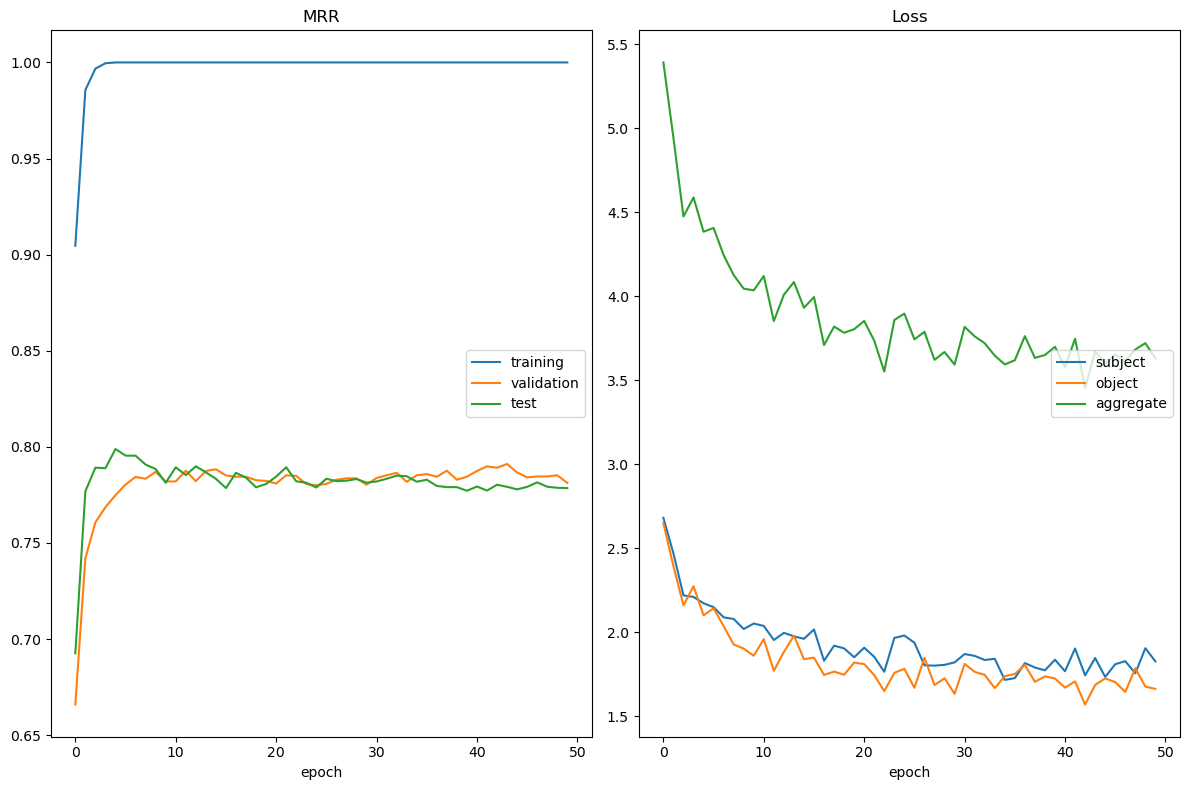

In [11]:
all_logs = []
primary = 'text_files/umls/'
img_path = 'outputs/graphs/umls/'

valid_path = primary + 'valid.tsv'
test_path = primary + 'test.tsv'

for i in [10, 25, 50, 100, 150, 200]:
    for j in ['gemma', 'gpt']:
        train_path = primary + f'nations_{i}_{j}.tsv'
        logs = main(train_path, valid_path, test_path, img_path = img_path, mod = 'comp')

        # Saving the logs for each iteration
        logs['Triples'] = f'{i}_{j}'
        all_logs.append(logs)

logs_df = pd.DataFrame(all_logs)
logs_df.to_csv('outputs/metrics/umls.csv', index = False)

# MISC - TO SORT LATER

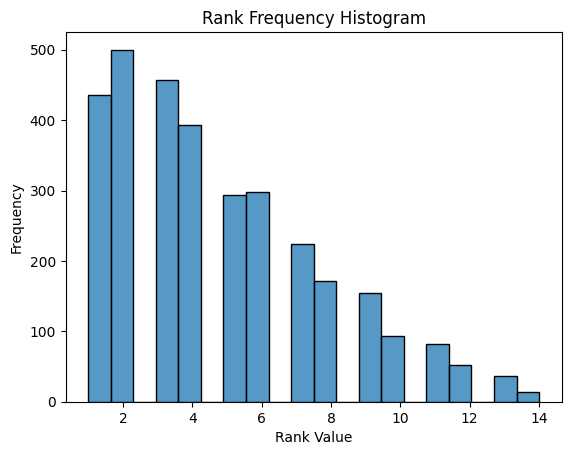

In [ ]:
train_metrics = evaluate(test_triples=train_t, all_triples=all_t, model=model)

# Plotting the histogram using seaborn
sns.histplot(train_metrics['ranks_l'] + train_metrics['ranks_r'], bins='auto', kde=False)

plt.xlabel('Rank Value')
plt.ylabel('Frequency')
plt.title('Rank Frequency Histogram')

# Display the plot
plt.show()

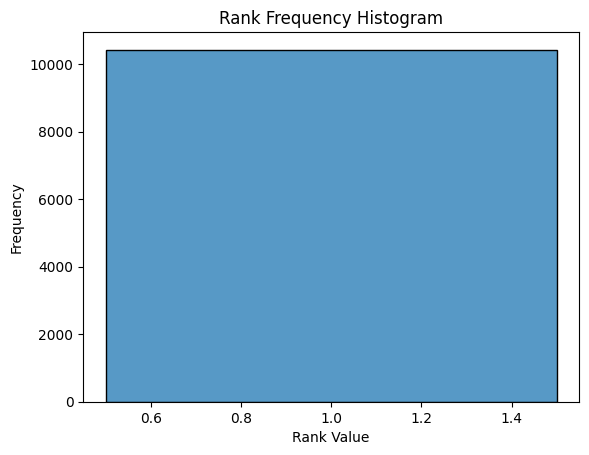

In [ ]:
train_metrics = evaluate(test_triples=train_t, all_triples=all_t, model=model)
valid_metrics = evaluate(test_triples=valid_t, all_triples=all_t, model=model)
# test_metrics = evaluate(test_triples=test_t, all_triples=all_t, model=model)

sns.histplot(train_metrics['ranks_l'] + train_metrics['ranks_r'], bins='auto', kde=False)

plt.xlabel('Rank Value')
plt.ylabel('Frequency')
plt.title('Rank Frequency Histogram')

plt.show()

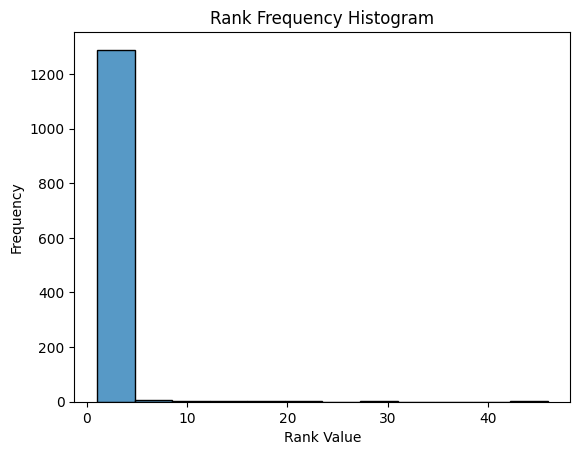

In [ ]:
sns.histplot(valid_metrics['ranks_l'] + valid_metrics['ranks_r'], bins='auto', kde=False)

plt.xlabel('Rank Value')
plt.ylabel('Frequency')
plt.title('Rank Frequency Histogram')

plt.show()